In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from nltk import Tree, grammar, CFG
import random

In [2]:
with open('sequoia-corpus+fct.mrg_strict', 'r') as file:
    data = file.read().splitlines()
    
file.close()

In [3]:
def ignore_functional_labels(string):
    
    """
    Description
    ----------------
    Ignore functional labels in the non terminals of a rule, for example PP-MOD becomes PP
    
    Parameters
    ----------------
    string : String form of parse tree.
    
    Returns
    ----------------
    new string form of parse tree
    """
    
    l = string.split(' ')
    for i in range(len(l)):
        if l[i][0] == '(':
            l[i] = l[i].split('-')[0]
            
    return ' '.join(l)
    

In [4]:
# t = Tree.fromstring(ignore_functional_labels(data[2]))
# t.chomsky_normal_form()
# t.productions()

In [5]:
def extract_nodes(rule):
    
    """
    Description
    ---------------
    Extract the non terminal and terminal nodes from a rule along with the status of the rule (either lexical 1, or not 0)
    
    Parameters
    ---------------
    rule : nltk.grammar.Production object, the rule to consider.
    
    Returns
    ---------------
    3-tuple, tuple[0] : the lexical status.
             tuple[1] : set containing the non terminal nodes.
             tuple[2] : set containing the terminal nodes.
    """
    if rule.is_lexical():
        return True, set((rule._lhs,)), set((rule._rhs))
    
    else:
        return False, set((rule._lhs,)).union(set(rule._rhs)), set()

In [6]:
non_terminals = set()
pos_tags = set()
terminals = set()
binaries = set()
for string in data:
    t = Tree.fromstring(ignore_functional_labels(string))
    t.chomsky_normal_form()
    rules = t.productions()
    for rule in rules:
        lexical, non_terminal_nodes, terminal_nodes = extract_nodes(rule)
        if lexical:
            non_terminals = non_terminals.union(non_terminal_nodes)
            pos_tags = pos_tags.union(non_terminal_nodes)
            terminals = terminals.union(terminal_nodes)
            
        else:
            non_terminals = non_terminals.union(non_terminal_nodes)
            if len(rule._rhs) == 2:
                binaries.add(rule._rhs)

non_terminals = non_terminals.difference(pos_tags)
start = rules[0]._lhs   # The start symbol
sent = rules[0]._rhs[0] # The previous start symbol

In [7]:
print('Number of terminals : %d' %len(terminals))
print('Number of POS tags : %d' %len(pos_tags))
print('Number of non terminals : %d' %len(non_terminals))
print('Number of binaries : %d' %len(binaries))

Number of terminals : 10378
Number of POS tags : 29
Number of non terminals : 5100
Number of binaries : 7269


In [8]:
# dict_non_terminals_indices = {non_terminal : index for index, non_terminal in enumerate(non_terminals)}
# dict_indices_non_terminals = {index : non_terminal for non_terminal, index in dict_non_terminals_indices.items()}

# dict_pos_indices = {pos : index for index, pos in enumerate(pos_tags)}
# dict_indices_pos = {index : pos for pos, index in dict_pos_indices.items()}

# dict_terminals_indices = {terminal : index for index, terminal in enumerate(terminals)}
# dict_indices_terminals = {index : terminal for terminal, index in dict_terminals_indices.items()}

# dict_binaries_indices = {binary : index for index, binary in enumerate(binaries)}
# dict_indices_terminals = {index : binary for binary, index in dict_binaries_indices.items()}

In [9]:
random.seed(0)
random.shuffle(data)
data_train, data_dev, data_test = data[:4*len(data)//5], data[4*len(data)//5:9*len(data)//10], data[9*len(data)//10:]
del data

## Create PCFG

In [10]:
def express_node(rule):
    
    """
    Description
    ---------------
    Express the nature of the rule and extract its left hand and right hand sides.
    
    Parameters
    ---------------
    rule : nltk.grammar.Production object, the rule to consider.
    
    Returns
    ---------------
    3-tuple, tuple[0] : String describing the rule {'lexical', 'start_node', 'unary', 'binary'}
             tuple[1] : nltk.grammar.Production, the left hand side of the rule.
             tuple[2] : nltk.grammar.Production, the right hand side of the rule.
    """
    if rule.is_lexical():
        return 'lexical', rule._lhs, rule._rhs[0]
    
    else:
        lhs, rhs = rule._lhs, rule._rhs
        if rhs[0] == sent:
            return 'start_node', lhs, rhs[0]
        
        elif len(rhs) == 1:
            return 'unary', lhs, rhs[0]
        
#         elif len(rhs) == 1 and rhs[0] == sent:
#             return 'start_node -> sent', lhs, rhs[0]
        
        elif len(rhs) == 2:
            return 'binary', lhs, rhs

In [14]:
# dict_lexicons, dict_unaries, dict_binaries = {}, {start : {sent : 1}}, {}

# for string in data_train:
#     t = Tree.fromstring(ignore_functional_labels(string))
#     t.chomsky_normal_form()
#     rules = t.productions()
#     for rule in rules:
#         nature, lhs, rhs = express_node(rule)
#         if nature == 'lexical':
#             if lhs in dict_lexicons:
#                 if rhs in dict_lexicons[lhs]:
#                     dict_lexicons[lhs][rhs] += 1
                    
#                 else:
#                     dict_lexicons[lhs][rhs] = 1
                    
#             else:
#                 dict_lexicons[lhs] = {rhs : 1}
                
#         elif nature == 'unary':
#             if lhs in dict_unaries:
#                 if rhs in dict_unaries[lhs]:
#                     dict_unaries[lhs][rhs] += 1
                    
#                 else:
#                     dict_unaries[lhs][rhs] = 1
                    
#             else:
#                 dict_unaries[lhs] = {rhs : 1}
                
#         elif nature == 'binary':
#             if lhs in dict_binaries:
#                 if rhs in dict_binaries[lhs]:
#                     dict_binaries[lhs][rhs] += 1
                    
#                 else:
#                     dict_binaries[lhs][rhs] = 1
                    
#             else:
#                 dict_binaries[lhs] = {rhs : 1}
                
#         elif nature == 'start_node':
#             continue

In [84]:
# data_dev

In [85]:
def pcfg(data):
    
    """
    Description
    ----------------
    Create PCFG model from the data, i.e compute the probability of each rule (conditiona probabilities) statistically from the data
    
    Parameters
    ----------------
    data : List of strings representing parse trees.
    
    Returns
    ----------------
    dict_pcfg   : Dictionnary with three keys {'lexical', 'unary', 'binary'}
                 - dict_pcfg['lexical']  : dictionnary of lexicons.
                                           - keys   : POS tags; 
                                           - values : dictionnary of probabilities p(terminal|POS_tag)
                                                     - keys   : terminals.
                                                     - values : p(terminal|POS_tag)
                 - dict_pcfg['unary']    : dictionnary of unary laws.
                                           - keys   : non terminals; 
                                           - values : dictionnary of probabilities p(node|non_terminal), node here can be
                                                      either a POS tag or a non terminal.
                                                     - keys   : non terminals.
                                                     - values : p(node|non_terminal)
                                                                          
                 - dict_pcfg['binary']   : dictionnary of binary laws.
                                           - keys   : non terminals; 
                                           - values : dictionnary of probabilities p(node|non_terminal), node here is binary
                                                      containing POS tags or non terminals.
                                                     - keys   : non terminals.
                                                     - values : p(node|non_terminal)
                                                                        
    dict_probas : Dictionnary rearranging the elements of dict_pcfg in a way that simplifies the use of the probabilities 
                  in the CYK algorithm.
                  - keys   : nodes, either POS tags or non terminals or binary nodes;
                  - values : dictionnary of probabilities.
                            - keys   : unary nodes (POS tags or non terminals).
                            - values : probabilities p(node|unary_node)
    """
    
    # Initalize dictionnaries dict_lexicons, dict_unaries, dict_binaries that we put in dict_pcfg
    dict_lexicons, dict_unaries, dict_binaries = {}, {start : {sent : 1}}, {} # Notice that we already put the rule of the start node in
                                                                              # Chomsky normal form
    dict_pcfg = {'lexical' : dict_lexicons, 'unary' : dict_unaries, 'binary' : dict_binaries}
    
    # Loop over the data
    for string in data:
        t = Tree.fromstring(ignore_functional_labels(string)) # Ignore the functional labels (see the doc of ignore_functional_labels)
        t.chomsky_normal_form()  # Convert the tree to Chomsky normal form
        rules = t.productions()  # Get the rules
        for rule in rules:       # We start by counting the rules in data
            nature, lhs, rhs = express_node(rule)
            if nature in ['lexical', 'unary', 'binary']:
                if lhs in dict_pcfg[nature]:
                    if rhs in dict_pcfg[nature][lhs]:
                        dict_pcfg[nature][lhs][rhs] += 1

                    else:
                        dict_pcfg[nature][lhs][rhs] = 1

                else:
                    dict_pcfg[nature][lhs] = {rhs : 1}

            elif nature == 'start_node':
                continue
                
    normalize = lambda dictionnary, key, value : value/sum(dictionnary.values()) # After counting the data, now we normalize the 
                                                                                 # dictionnaries in order to get probabilities.
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            dict_pcfg[nature][lhs] = dict((key, normalize(dict_pcfg[nature][lhs], key, value)) for key, value in dict_pcfg[nature][lhs].items())
            
    dict_probas = {} # Initialize dict_probas
    for nature in dict_pcfg:
        for lhs in dict_pcfg[nature]:
            for node in dict_pcfg[nature][lhs]:
                if node in dict_probas:
                    dict_probas[node][lhs] = dict_pcfg[nature][lhs][node]

                else:
                    dict_probas[node] = {lhs : dict_pcfg[nature][lhs][node]}
                    
    return dict_pcfg, dict_probas




In [86]:
dict_pcfg, dict_probas = pcfg(data_train)

In [63]:
# dict_lexicons, dict_unaries, dict_binaries = {}, {start : {sent : 1}}, {}
# dict_pcfg = {'lexical' : dict_lexicons, 'unary' : dict_unaries, 'binary' : dict_binaries}

# for string in data_train:
#     t = Tree.fromstring(ignore_functional_labels(string))
#     t.chomsky_normal_form()
#     rules = t.productions()
#     for rule in rules:
#         nature, lhs, rhs = express_node(rule)
#         if nature in ['lexical', 'unary', 'binary']:
#             if lhs in dict_pcfg[nature]:
#                 if rhs in dict_pcfg[nature][lhs]:
#                     dict_pcfg[nature][lhs][rhs] += 1
                    
#                 else:
#                     dict_pcfg[nature][lhs][rhs] = 1
                    
#             else:
#                 dict_pcfg[nature][lhs] = {rhs : 1}
                
#         elif nature == 'start_node':
#             continue

# # Normalize to compute the probabilities
# normalize = lambda dictionnary, key, value : value/sum(dictionnary.values())
# for nature in dict_pcfg:
#     for lhs in dict_pcfg[nature]:
#         dict_pcfg[nature][lhs] = dict((key, normalize(dict_pcfg[nature][lhs], key, value)) for key, value in dict_pcfg[nature][lhs].items())
    
# dict_probas = {}
# for nature in dict_pcfg:
#     for lhs in dict_pcfg[nature]:
#         for node in dict_pcfg[nature][lhs]:
#             if node in dict_probas:
#                 dict_probas[node][lhs] = dict_pcfg[nature][lhs][node]
                
#             else:
#                 dict_probas[node] = {lhs : dict_pcfg[nature][lhs][node]}
        

In [ ]:
def cyk(sentence):
    
    n = len(sentence) + 1
    k = len(non_terminals)
    scores = np.zeros((n, n, k))
    back = [[[None for i in range(k)] for j in range(n)] for l in range(n)]
    for i in range(0, n-1):
        for A in pos_tags:
            scores[i, i+1, dict_non_terminals_indices[A]] = plexicon[dict_pos_indices[A], dict_terminals_indices[sentence[i]]]
            scores[i, i+1, dict_non_terminals_indices[A]] = plexicon[dict_pos_indices[A], dict_terminals_indices[sentence[i]]]
                        
        added = True
        while added:
            added = False
            for B in non_terminals:
                if scores[i, i+1, dict_non_terminals_indices[B]] > 0:
                    for A in non_terminals:
                        prob = pcfg_unary[dict_non_terminals_indices[A], dict_non_terminals_indices[B]]*scores[i, i+1, dict_non_terminals_indices[B]]
                        if prob > scores[i, i+1, dict_non_terminals_indices[A]]:
                            scores[i, i+1, dict_non_terminals_indices[A]] = prob
                            back[i][i+1][dict_non_terminals_indices[A]] = B
                            added = True
                                                        
    for span in range(2, n):
        for begin in range(0, n-span):
            print(begin)
            end = begin + span
            for split in range(begin+1, end):
                for B, C in binaries:
                    if (scores[begin, split, dict_non_terminals_indices[B]] > 0) and (scores[begin, split, dict_non_terminals_indices[C]] > 0):
                        for A in non_terminals:
                            prob = scores[begin, split, dict_non_terminals_indices[B]]*scores[begin, split, dict_non_terminals_indices[C]]*pcfg_binary[dict_non_terminals_indices[A], dict_binaries_indices[(B, C)]]
                            if prob > scores[begin, end, dict_non_terminals_indices[A]]:
                                scores[begin, end, dict_non_terminals_indices[A]] = prob
                                back[begin][end][dict_non_terminals_indices[A]] = (split, B, C)
                                
            added = True
            while added:
                added = False
                for B in non_terminals:
                    if scores[begin, end, dict_non_terminals_indices[B]] > 0:
                        for A in non_terminals:
                            prob = pcfg_unary[dict_non_terminals_indices[A], dict_non_terminals_indices[B]]*scores[begin, end, dict_non_terminals_indices[B]]
                            if prob > scores[begin, end, dict_non_terminals_indices[A]]:
                                scores[begin, end, dict_non_terminals_indices[A]] = prob
                                back[begin][end][dict_non_terminals_indices[A]] = B
                                added = True
                                
                                
    return scores, back

In [170]:
def cyk(sentence):
    
    n = len(sentence) + 1
    k = len(non_terminals)
    scores = np.zeros((n, n, k))
    back = [[[None for i in range(k)] for j in range(n)] for l in range(n)]
    for i in range(0, n-1):
        for A in pos_tags:
            scores[i, i+1, dict_non_terminals_indices[A]] = plexicon[dict_pos_indices[A], dict_terminals_indices[sentence[i]]]
                        
        added = True
        while added:
            added = False
            for B in non_terminals:
                if scores[i, i+1, dict_non_terminals_indices[B]] > 0:
                    for A in non_terminals:
                        prob = pcfg_unary[dict_non_terminals_indices[A], dict_non_terminals_indices[B]]*scores[i, i+1, dict_non_terminals_indices[B]]
                        if prob > scores[i, i+1, dict_non_terminals_indices[A]]:
                            scores[i, i+1, dict_non_terminals_indices[A]] = prob
                            back[i][i+1][dict_non_terminals_indices[A]] = B
                            added = True
                                                        
    for span in range(2, n):
        for begin in range(0, n-span):
            print(begin)
            end = begin + span
            for split in range(begin+1, end):
                for B, C in binaries:
                    if (scores[begin, split, dict_non_terminals_indices[B]] > 0) and (scores[begin, split, dict_non_terminals_indices[C]] > 0):
                        for A in non_terminals:
                            prob = scores[begin, split, dict_non_terminals_indices[B]]*scores[begin, split, dict_non_terminals_indices[C]]*pcfg_binary[dict_non_terminals_indices[A], dict_binaries_indices[(B, C)]]
                            if prob > scores[begin, end, dict_non_terminals_indices[A]]:
                                scores[begin, end, dict_non_terminals_indices[A]] = prob
                                back[begin][end][dict_non_terminals_indices[A]] = (split, B, C)
                                
            added = True
            while added:
                added = False
                for B in non_terminals:
                    if scores[begin, end, dict_non_terminals_indices[B]] > 0:
                        for A in non_terminals:
                            prob = pcfg_unary[dict_non_terminals_indices[A], dict_non_terminals_indices[B]]*scores[begin, end, dict_non_terminals_indices[B]]
                            if prob > scores[begin, end, dict_non_terminals_indices[A]]:
                                scores[begin, end, dict_non_terminals_indices[A]] = prob
                                back[begin][end][dict_non_terminals_indices[A]] = B
                                added = True
                                
                                
    return scores, back

In [187]:
t = Tree.fromstring(data_train[25])
t.chomsky_normal_form()

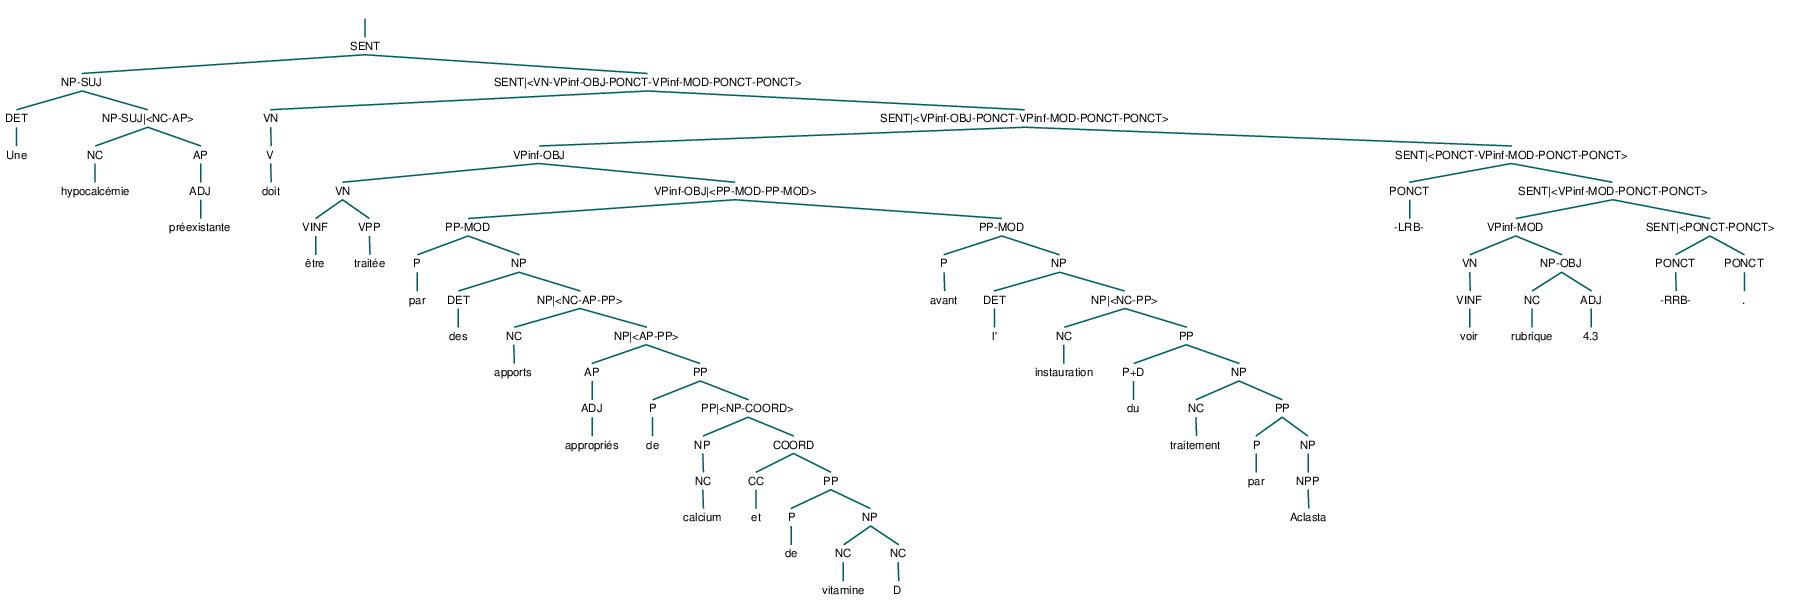

In [188]:
t

In [190]:
for string in data_train:
    t = Tree.fromstring(ignore_functional_labels(string))
    if len(t.leaves()) <= 4:
        break

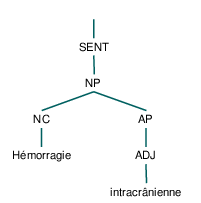

In [193]:
t

In [192]:
sentence = t.leaves()

In [194]:
sentence

['Hémorragie', 'intracrânienne']

In [195]:
len(sentence)

2

In [196]:
scores, back = cyk(sentence)

0


In [202]:
scores.shape

(3, 3, 5129)